In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

from tensorflow.python.keras.models import Model
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Lambda
from tensorflow.python.keras.layers import Activation
from tensorflow.python.keras.layers import Concatenate
from tensorflow.python.keras.layers import Add
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.layers import DepthwiseConv2D
from tensorflow.python.keras.layers import ZeroPadding2D
from tensorflow.python.keras.layers import GlobalAveragePooling2D
from tensorflow.python.keras.utils.layer_utils import get_source_inputs
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.applications.imagenet_utils import preprocess_input
import keras
from keras.models import *
from keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import backend as keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input, MaxPooling2D
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.utils import np_utils
from keras.applications.vgg16 import VGG16
from keras.applications import DenseNet121
#from keras.applications import ResNet50V2
from keras.applications import InceptionResNetV2
from keras import backend as K
import skimage.io as io
import skimage.transform as trans
import numpy as np

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode
import torch
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import gc
from random import randint
init_notebook_mode(connected=True)
%matplotlib inline
np.set_printoptions(threshold=np.inf)
%cd D:\hüseyin
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using TensorFlow backend.


D:\hüseyin


In [2]:
train_images = np.load("images1.npy")
train_masks = np.load("masks1.npy")
images2 = np.load("images2.npy")
masks2 = np.load("masks2.npy")
train_images = np.append(train_images, images2, axis=0)
train_masks = np.append(train_masks, masks2, axis=0)
train_masks = train_masks[:,:,:,5]
print("Folder_1",train_images.shape, train_masks.shape)
unique, counts = np.unique(train_masks, return_counts=True)
dict(zip(unique, counts))

Folder_1 (5179, 256, 256, 3) (5179, 256, 256)


{0.0: 62506338, 1.0: 276904606}

In [3]:
train_masks[train_masks==1] = 2
train_masks[train_masks==0] = 1
train_masks[train_masks==2] = 0
unique, counts = np.unique(train_masks, return_counts=True)
dict(zip(unique, counts))

{0.0: 276904606, 1.0: 62506338}

In [3]:
train_images = train_images/255
train_masks = train_masks.reshape(train_masks.shape[0],256,256)
train_images.shape, train_masks.shape

((5179, 256, 256, 3), (5179, 256, 256))

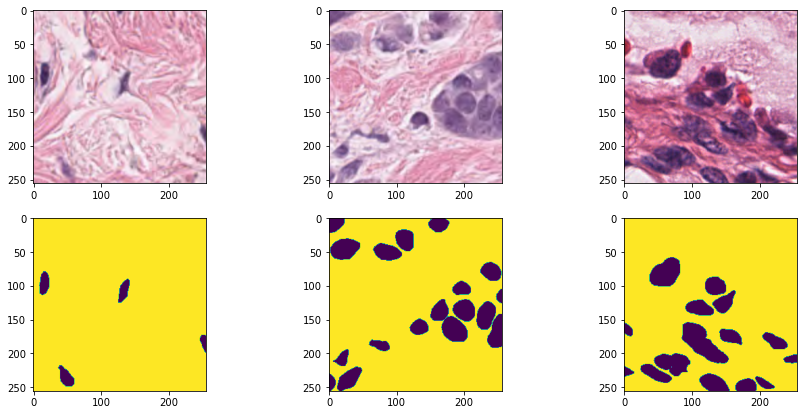

In [4]:
index = 80
f, axarr = plt.subplots(2,3, figsize=(15,7))
axarr[0,0].imshow(train_images[index])
axarr[0,1].imshow(train_images[index+158])
axarr[0,2].imshow(train_images[index+2498])
axarr[1,0].imshow(train_masks[index])
axarr[1,1].imshow(train_masks[index+158])
axarr[1,2].imshow(train_masks[index+2498])

In [2]:
import keras
from keras.models import *
from keras.layers import *
from keras import layers

# Source:
# https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py


IMAGE_ORDERING = 'channels_last'

def one_side_pad(x):
    x = ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING)(x)
    if IMAGE_ORDERING == 'channels_first':
        x = Lambda(lambda x: x[:, :, :-1, :-1])(x)
    elif IMAGE_ORDERING == 'channels_last':
        x = Lambda(lambda x: x[:, :-1, :-1, :])(x)
    return x


def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at
                     main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters

    if IMAGE_ORDERING == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), data_format=IMAGE_ORDERING,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, data_format=IMAGE_ORDERING,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), data_format=IMAGE_ORDERING,
               name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block,
               strides=(2, 2)):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at
                     main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with
    strides=(2,2) and the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters

    if IMAGE_ORDERING == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), data_format=IMAGE_ORDERING, strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, data_format=IMAGE_ORDERING,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), data_format=IMAGE_ORDERING,
               name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), data_format=IMAGE_ORDERING,
                      strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(
        axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x


def get_resnet50_encoder(input_height=256,  input_width=256,
                         pretrained='imagenet',
                         include_top=True, weights='imagenet',
                         input_tensor=None, input_shape=None,
                         pooling=None,
                         classes=1000, channels=3):

    assert input_height % 32 == 0
    assert input_width % 32 == 0

    if IMAGE_ORDERING == 'channels_first':
        img_input = Input(shape=(channels, input_height, input_width))
    elif IMAGE_ORDERING == 'channels_last':
        img_input = Input(shape=(input_height, input_width, channels))

    if IMAGE_ORDERING == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((3, 3), data_format=IMAGE_ORDERING)(img_input)
    x = Conv2D(64, (7, 7), data_format=IMAGE_ORDERING,
               strides=(2, 2), name='conv1')(x)
    f1 = x

    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), data_format=IMAGE_ORDERING, strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')
    f2 = one_side_pad(x)

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
    f3 = x

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')
    f4 = x

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    f5 = x

    x = AveragePooling2D(
        (7, 7), data_format=IMAGE_ORDERING, name='avg_pool')(x)
    # f6 = x

    if pretrained == 'imagenet':
        weights_path = keras.utils.get_file(
            pretrained_url.split("/")[-1], pretrained_url)
        Model(img_input, x).load_weights(weights_path, by_name=True, skip_mismatch=True)

    return img_input, [f1, f2, f3, f4, f5]

from keras.models import *
from keras.layers import *
import keras.backend as K



def vanilla_encoder(input_height=256,  input_width=256, channels=3):

    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2

    if IMAGE_ORDERING == 'channels_first':
        img_input = Input(shape=(channels, input_height, input_width))
    elif IMAGE_ORDERING == 'channels_last':
        img_input = Input(shape=(input_height, input_width, channels))

    x = img_input
    levels = []

    x = (ZeroPadding2D((pad, pad), data_format=IMAGE_ORDERING))(x)
    x = (Conv2D(filter_size, (kernel, kernel),
                data_format=IMAGE_ORDERING, padding='valid'))(x)
    x = (BatchNormalization())(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D((pool_size, pool_size), data_format=IMAGE_ORDERING))(x)
    levels.append(x)

    x = (ZeroPadding2D((pad, pad), data_format=IMAGE_ORDERING))(x)
    x = (Conv2D(128, (kernel, kernel), data_format=IMAGE_ORDERING,
         padding='valid'))(x)
    x = (BatchNormalization())(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D((pool_size, pool_size), data_format=IMAGE_ORDERING))(x)
    levels.append(x)

    for _ in range(3):
        x = (ZeroPadding2D((pad, pad), data_format=IMAGE_ORDERING))(x)
        x = (Conv2D(256, (kernel, kernel),
                    data_format=IMAGE_ORDERING, padding='valid'))(x)
        x = (BatchNormalization())(x)
        x = (Activation('relu'))(x)
        x = (MaxPooling2D((pool_size, pool_size),
             data_format=IMAGE_ORDERING))(x)
        levels.append(x)

    return img_input, levels

from keras.models import *
from keras.layers import *
import keras.backend as K
import keras


BASE_WEIGHT_PATH = ('https://github.com/fchollet/deep-learning-models/'
                    'releases/download/v0.6/')


def relu6(x):
    return K.relu(x, max_value=6)


def _conv_block(inputs, filters, alpha, kernel=(3, 3), strides=(1, 1)):

    channel_axis = 1 if IMAGE_ORDERING == 'channels_first' else -1
    filters = int(filters * alpha)
    x = ZeroPadding2D(padding=(1, 1), name='conv1_pad',
                      data_format=IMAGE_ORDERING)(inputs)
    x = Conv2D(filters, kernel, data_format=IMAGE_ORDERING,
               padding='valid',
               use_bias=False,
               strides=strides,
               name='conv1')(x)
    x = BatchNormalization(axis=channel_axis, name='conv1_bn')(x)
    return Activation(relu6, name='conv1_relu')(x)


def _depthwise_conv_block(inputs, pointwise_conv_filters, alpha,
                          depth_multiplier=1, strides=(1, 1), block_id=1):

    channel_axis = 1 if IMAGE_ORDERING == 'channels_first' else -1
    pointwise_conv_filters = int(pointwise_conv_filters * alpha)

    x = ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING,
                      name='conv_pad_%d' % block_id)(inputs)
    x = DepthwiseConv2D((3, 3), data_format=IMAGE_ORDERING,
                        padding='valid',
                        depth_multiplier=depth_multiplier,
                        strides=strides,
                        use_bias=False,
                        name='conv_dw_%d' % block_id)(x)
    x = BatchNormalization(
        axis=channel_axis, name='conv_dw_%d_bn' % block_id)(x)
    x = Activation(relu6, name='conv_dw_%d_relu' % block_id)(x)

    x = Conv2D(pointwise_conv_filters, (1, 1), data_format=IMAGE_ORDERING,
               padding='same',
               use_bias=False,
               strides=(1, 1),
               name='conv_pw_%d' % block_id)(x)
    x = BatchNormalization(axis=channel_axis,
                           name='conv_pw_%d_bn' % block_id)(x)
    return Activation(relu6, name='conv_pw_%d_relu' % block_id)(x)


def get_mobilenet_encoder(input_height=256, input_width=256,
                          pretrained='imagenet', channels=3):

    # todo add more alpha and stuff

    assert (K.image_data_format() ==
            'channels_last'), "Currently only channels last mode is supported"
    assert (IMAGE_ORDERING ==
            'channels_last'), "Currently only channels last mode is supported"
    assert (input_height == 224), \
        "For mobilenet , 224 input_height is supported "
    assert (input_width == 224), "For mobilenet , 224 width is supported "

    assert input_height % 32 == 0
    assert input_width % 32 == 0

    alpha = 1.0
    depth_multiplier = 1
    dropout = 1e-3

    img_input = Input(shape=(input_height, input_width, channels))

    x = _conv_block(img_input, 32, alpha, strides=(2, 2))
    x = _depthwise_conv_block(x, 64, alpha, depth_multiplier, block_id=1)
    f1 = x

    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier,
                              strides=(2, 2), block_id=2)
    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier, block_id=3)
    f2 = x

    x = _depthwise_conv_block(x, 256, alpha, depth_multiplier,
                              strides=(2, 2), block_id=4)
    x = _depthwise_conv_block(x, 256, alpha, depth_multiplier, block_id=5)
    f3 = x

    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier,
                              strides=(2, 2), block_id=6)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=7)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=8)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=9)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=10)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=11)
    f4 = x

    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier,
                              strides=(2, 2), block_id=12)
    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier, block_id=13)
    f5 = x

    if pretrained == 'imagenet':
        model_name = 'mobilenet_%s_%d_tf_no_top.h5' % ('1_0', 224)

        weight_path = BASE_WEIGHT_PATH + model_name
        weights_path = keras.utils.get_file(model_name, weight_path)

        Model(img_input, x).load_weights(weights_path, by_name=True, skip_mismatch=True)

    return img_input, [f1, f2, f3, f4, f5]

import keras
from keras.models import *
from keras.layers import *



def get_vgg_encoder(input_height=224,  input_width=224, pretrained='imagenet', channels=3):
    
    if IMAGE_ORDERING == 'channels_first':
            pretrained_url = "https://github.com/fchollet/deep-learning-models/" \
                     "releases/download/v0.1/" \
                     "vgg16_weights_th_dim_ordering_th_kernels_notop.h5"
    elif IMAGE_ORDERING == 'channels_last':
        pretrained_url = "https://github.com/fchollet/deep-learning-models/" \
                     "releases/download/v0.1/" \
                     "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"


    assert input_height % 32 == 0
    assert input_width % 32 == 0

    if IMAGE_ORDERING == 'channels_first':
        img_input = Input(shape=(channels, input_height, input_width))
    elif IMAGE_ORDERING == 'channels_last':
        img_input = Input(shape=(input_height, input_width, channels))

    x = Conv2D(64, (3, 3), activation='relu', padding='same',
               name='block1_conv1', data_format=IMAGE_ORDERING)(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same',
               name='block1_conv2', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool',
                     data_format=IMAGE_ORDERING)(x)
    f1 = x
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same',
               name='block2_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same',
               name='block2_conv2', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool',
                     data_format=IMAGE_ORDERING)(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same',
               name='block3_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same',
               name='block3_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same',
               name='block3_conv3', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool',
                     data_format=IMAGE_ORDERING)(x)
    f3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block4_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block4_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block4_conv3', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool',
                     data_format=IMAGE_ORDERING)(x)
    f4 = x

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block5_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block5_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block5_conv3', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool',
                     data_format=IMAGE_ORDERING)(x)
    f5 = x

    if pretrained == 'imagenet':
        VGG_Weights_path = keras.utils.get_file(
            pretrained_url.split("/")[-1], pretrained_url)
        Model(img_input, x).load_weights(VGG_Weights_path, by_name=True, skip_mismatch=True)

    return img_input, [f1, f2, f3, f4, f5]

from types import MethodType

from keras.models import *
from keras.layers import *
import keras.backend as K
from tqdm import tqdm


# source m1 , dest m2
def transfer_weights(m1, m2, verbose=True):

    assert len(m1.layers) == len(
        m2.layers), "Both models should have same number of layers"

    nSet = 0
    nNotSet = 0

    if verbose:
        print("Copying weights ")
        bar = tqdm(zip(m1.layers, m2.layers))
    else:
        bar = zip(m1.layers, m2.layers)

    for l, ll in bar:

        if not any([w.shape != ww.shape for w, ww in zip(list(l.weights),
                                                         list(ll.weights))]):
            if len(list(l.weights)) > 0:
                ll.set_weights(l.get_weights())
                nSet += 1
        else:
            nNotSet += 1

    if verbose:
        print("Copied weights of %d layers and skipped %d layers" %
              (nSet, nNotSet))


def resize_image(inp,  s, data_format):

    try:

        return Lambda(lambda x: K.resize_images(x,
                                                height_factor=s[0],
                                                width_factor=s[1],
                                                data_format=data_format,
                                                interpolation='bilinear'))(inp)

    except Exception as e:
        # if keras is old, then rely on the tf function
        # Sorry theano/cntk users!!!
        assert data_format == 'channels_last'
        assert IMAGE_ORDERING == 'channels_last'

        import tensorflow as tf

        return Lambda(
            lambda x: tf.image.resize_images(
                x, (K.int_shape(x)[1]*s[0], K.int_shape(x)[2]*s[1]))
        )(inp)


def get_segmentation_model(img_input, output):

    i = img_input
    o = output

    o_shape = Model(i, o).output_shape
    i_shape = Model(i, o).input_shape

    if IMAGE_ORDERING == 'channels_first':
        output_height = o_shape[2]
        output_width = o_shape[3]
        input_height = i_shape[2]
        input_width = i_shape[3]
        n_classes = o_shape[1]
        o = (Reshape((-1, output_height, output_width)))(o)
        o = (Permute((2, 1)))(o)
    elif IMAGE_ORDERING == 'channels_last':
        output_height = o_shape[1]
        output_width = o_shape[2]
        input_height = i_shape[1]
        input_width = i_shape[2]
        n_classes = o_shape[3]
        o = (Reshape((output_height, output_width, -1)))(o)

    o = (Activation('sigmoid'))(o)
    model = Model(img_input, o)
    model.output_width = output_width
    model.output_height = output_height
    model.n_classes = n_classes
    model.input_height = input_height
    model.input_width = input_width
    model.model_name = ""

    model.train = MethodType(train, model)
    model.predict_segmentation = MethodType(predict, model)
    model.predict_multiple = MethodType(predict_multiple, model)
    model.evaluate_segmentation = MethodType(evaluate, model)

    return model

In [3]:
import numpy as np

try:
    import imgaug as ia
    from imgaug import augmenters as iaa
except ImportError:
    print("Error in loading augmentation, can't import imgaug."
          "Please make sure it is installed.")


IMAGE_AUGMENTATION_SEQUENCE = None
IMAGE_AUGMENTATION_NUM_TRIES = 10

loaded_augmentation_name = ""


def _load_augmentation_aug_geometric():
    return iaa.OneOf([
        iaa.Sequential([iaa.Fliplr(0.5), iaa.Flipud(0.2)]),
        iaa.CropAndPad(percent=(-0.05, 0.1),
                       pad_mode='constant',
                       pad_cval=(0, 255)),
        iaa.Crop(percent=(0.0, 0.1)),
        iaa.Crop(percent=(0.3, 0.5)),
        iaa.Crop(percent=(0.3, 0.5)),
        iaa.Crop(percent=(0.3, 0.5)),
        iaa.Sequential([
            iaa.Affine(
                    # scale images to 80-120% of their size,
                    # individually per axis
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                    # translate by -20 to +20 percent (per axis)
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                    rotate=(-45, 45),  # rotate by -45 to +45 degrees
                    shear=(-16, 16),  # shear by -16 to +16 degrees
                    # use nearest neighbour or bilinear interpolation (fast)
                    order=[0, 1],
                    # if mode is constant, use a cval between 0 and 255
                    mode='constant',
                    cval=(0, 255),
                    # use any of scikit-image's warping modes
                    # (see 2nd image from the top for examples)
            ),
            iaa.Sometimes(0.3, iaa.Crop(percent=(0.3, 0.5)))])
    ])


def _load_augmentation_aug_non_geometric():
    return iaa.Sequential([
        iaa.Sometimes(0.3, iaa.Multiply((0.5, 1.5), per_channel=0.5)),
        iaa.Sometimes(0.2, iaa.JpegCompression(compression=(70, 99))),
        iaa.Sometimes(0.2, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Sometimes(0.2, iaa.MotionBlur(k=15, angle=[-45, 45])),
        iaa.Sometimes(0.2, iaa.MultiplyHue((0.5, 1.5))),
        iaa.Sometimes(0.2, iaa.MultiplySaturation((0.5, 1.5))),
        iaa.Sometimes(0.34, iaa.MultiplyHueAndSaturation((0.5, 1.5),
                                                         per_channel=True)),
        iaa.Sometimes(0.34, iaa.Grayscale(alpha=(0.0, 1.0))),
        iaa.Sometimes(0.2, iaa.ChangeColorTemperature((1100, 10000))),
        iaa.Sometimes(0.1, iaa.GammaContrast((0.5, 2.0))),
        iaa.Sometimes(0.2, iaa.SigmoidContrast(gain=(3, 10),
                                               cutoff=(0.4, 0.6))),
        iaa.Sometimes(0.1, iaa.CLAHE()),
        iaa.Sometimes(0.1, iaa.HistogramEqualization()),
        iaa.Sometimes(0.2, iaa.LinearContrast((0.5, 2.0), per_channel=0.5)),
        iaa.Sometimes(0.1, iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)))
    ])


def _load_augmentation_aug_all2():
    return iaa.Sequential([
        iaa.Sometimes(0.65, _load_augmentation_aug_non_geometric()),
        iaa.Sometimes(0.65, _load_augmentation_aug_geometric())
    ])


def _load_augmentation_aug_all():
    """ Load image augmentation model """

    def sometimes(aug):
        return iaa.Sometimes(0.5, aug)

    return iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5),  # horizontally flip 50% of all images
            iaa.Flipud(0.2),  # vertically flip 20% of all images
            # crop images by -5% to 10% of their height/width
            sometimes(iaa.CropAndPad(
                percent=(-0.05, 0.1),
                pad_mode='constant',
                pad_cval=(0, 255)
            )),
            sometimes(iaa.Affine(
                # scale images to 80-120% of their size, individually per axis
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                # translate by -20 to +20 percent (per axis)
                translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                rotate=(-45, 45),  # rotate by -45 to +45 degrees
                shear=(-16, 16),  # shear by -16 to +16 degrees
                # use nearest neighbour or bilinear interpolation (fast)
                order=[0, 1],
                # if mode is constant, use a cval between 0 and 255
                cval=(0, 255),
                # use any of scikit-image's warping modes
                # (see 2nd image from the top for examples)
                mode='constant'
            )),
            # execute 0 to 5 of the following (less important) augmenters per
            # image don't execute all of them, as that would often be way too
            # strong
            iaa.SomeOf((0, 5),
                       [
                # convert images into their superpixel representation
                sometimes(iaa.Superpixels(
                    p_replace=(0, 1.0), n_segments=(20, 200))),
                iaa.OneOf([
                    # blur images with a sigma between 0 and 3.0
                    iaa.GaussianBlur((0, 3.0)),
                    # blur image using local means with kernel sizes
                    # between 2 and 7
                    iaa.AverageBlur(k=(2, 7)),
                    # blur image using local medians with kernel sizes
                    # between 2 and 7
                    iaa.MedianBlur(k=(3, 11)),
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(
                            0.75, 1.5)),  # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(
                    0, 2.0)),  # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.BlendAlphaSimplexNoise(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(
                        alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                # add gaussian noise to images
                iaa.AdditiveGaussianNoise(loc=0, scale=(
                    0.0, 0.05*255), per_channel=0.5),
                iaa.OneOf([
                    # randomly remove up to 10% of the pixels
                    iaa.Dropout((0.01, 0.1), per_channel=0.5),
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(
                        0.02, 0.05), per_channel=0.2),
                ]),
                # invert color channels
                iaa.Invert(0.05, per_channel=True),
                # change brightness of images (by -10 to 10 of original value)
                iaa.Add((-10, 10), per_channel=0.5),
                # change hue and saturation
                iaa.AddToHueAndSaturation((-20, 20)),
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply(
                                (0.5, 1.5), per_channel=0.5),
                    iaa.BlendAlphaFrequencyNoise(
                        exponent=(-4, 0),
                        foreground=iaa.Multiply(
                            (0.5, 1.5), per_channel=True),
                        background=iaa.contrast.LinearContrast(
                            (0.5, 2.0))
                    )
                ]),
                # improve or worsen the contrast
                iaa.contrast.LinearContrast((0.5, 2.0), per_channel=0.5),
                iaa.Grayscale(alpha=(0.0, 1.0)),
                # move pixels locally around (with random strengths)
                sometimes(iaa.ElasticTransformation(
                    alpha=(0.5, 3.5), sigma=0.25)),
                # sometimes move parts of the image around
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))),
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
                random_order=True
            )
        ],
        random_order=True
    )


augmentation_functions = {
    "aug_all": _load_augmentation_aug_all,
    "aug_all2": _load_augmentation_aug_all2,
    "aug_geometric": _load_augmentation_aug_geometric,
    "aug_non_geometric": _load_augmentation_aug_non_geometric
}


def _load_augmentation(augmentation_name="aug_all"):

    global IMAGE_AUGMENTATION_SEQUENCE

    if augmentation_name not in augmentation_functions:
        raise ValueError("Augmentation name not supported")

    IMAGE_AUGMENTATION_SEQUENCE = augmentation_functions[augmentation_name]()


def _augment_seg(img, seg, augmentation_name="aug_all", other_imgs=None):

    global loaded_augmentation_name

    if (not IMAGE_AUGMENTATION_SEQUENCE) or\
       (augmentation_name != loaded_augmentation_name):
        _load_augmentation(augmentation_name)
        loaded_augmentation_name = augmentation_name

    # Create a deterministic augmentation from the random one
    aug_det = IMAGE_AUGMENTATION_SEQUENCE.to_deterministic()
    # Augment the input image
    image_aug = aug_det.augment_image(img)

    if other_imgs is not None:
        image_aug = [image_aug]

        for other_img in other_imgs:
            image_aug.append(aug_det.augment_image(other_img))

    segmap = ia.SegmentationMapsOnImage(
        seg, shape=img.shape)
    segmap_aug = aug_det.augment_segmentation_maps(segmap)
    segmap_aug = segmap_aug.get_arr()

    return image_aug, segmap_aug


def _custom_augment_seg(img, seg, augmentation_function, other_imgs=None):
    augmentation_functions['custom_aug'] = augmentation_function

    return _augment_seg(img, seg, "custom_aug", other_imgs=other_imgs)


def _try_n_times(fn, n, *args, **kargs):
    """ Try a function N times """
    attempts = 0
    while attempts < n:
        try:
            return fn(*args, **kargs)
        except Exception:
            attempts += 1

    return fn(*args, **kargs)


def augment_seg(img, seg, augmentation_name="aug_all", other_imgs=None):
    return _try_n_times(_augment_seg, IMAGE_AUGMENTATION_NUM_TRIES,
                        img, seg, augmentation_name=augmentation_name,
                        other_imgs=other_imgs)


def custom_augment_seg(img, seg, augmentation_function, other_imgs=None):
    return _try_n_times(_custom_augment_seg, IMAGE_AUGMENTATION_NUM_TRIES,
                        img, seg, augmentation_function=augmentation_function,
                        other_imgs=other_imgs)
import itertools
import os
import random
import six
import numpy as np
import cv2

try:
    from collections.abc import Sequence
except ImportError:
    from collections import Sequence

try:
    from tqdm import tqdm
except ImportError:
    print("tqdm not found, disabling progress bars")

    def tqdm(iter):
        return iter


DATA_LOADER_SEED = 0

random.seed(DATA_LOADER_SEED)
class_colors = [(random.randint(0, 255), random.randint(
    0, 255), random.randint(0, 255)) for _ in range(5000)]


class DataLoaderError(Exception):
    pass


def get_pairs_from_paths(images_path, segs_path, ignore_non_matching=False, other_inputs_paths=None):
    """ Find all the images from the images_path directory and
        the segmentation images from the segs_path directory
        while checking integrity of data """

    ACCEPTABLE_IMAGE_FORMATS = [".jpg", ".jpeg", ".png", ".bmp"]
    ACCEPTABLE_SEGMENTATION_FORMATS = [".png", ".bmp"]

    image_files = []
    segmentation_files = {}

    for dir_entry in os.listdir(images_path):
        if os.path.isfile(os.path.join(images_path, dir_entry)) and \
                os.path.splitext(dir_entry)[1] in ACCEPTABLE_IMAGE_FORMATS:
            file_name, file_extension = os.path.splitext(dir_entry)
            image_files.append((file_name, file_extension,
                                os.path.join(images_path, dir_entry)))

    if other_inputs_paths is not None:
        other_inputs_files = []

        for i, other_inputs_path in enumerate(other_inputs_paths):
            temp = []

            for y, dir_entry in enumerate(os.listdir(other_inputs_path)):
                if os.path.isfile(os.path.join(other_inputs_path, dir_entry)) and \
                        os.path.splitext(dir_entry)[1] in ACCEPTABLE_IMAGE_FORMATS:
                    file_name, file_extension = os.path.splitext(dir_entry)

                    temp.append((file_name, file_extension,
                                 os.path.join(other_inputs_path, dir_entry)))

            other_inputs_files.append(temp)

    for dir_entry in os.listdir(segs_path):
        if os.path.isfile(os.path.join(segs_path, dir_entry)) and \
           os.path.splitext(dir_entry)[1] in ACCEPTABLE_SEGMENTATION_FORMATS:
            file_name, file_extension = os.path.splitext(dir_entry)
            full_dir_entry = os.path.join(segs_path, dir_entry)
            if file_name in segmentation_files:
                raise DataLoaderError("Segmentation file with filename {0}"
                                      " already exists and is ambiguous to"
                                      " resolve with path {1}."
                                      " Please remove or rename the latter."
                                      .format(file_name, full_dir_entry))

            segmentation_files[file_name] = (file_extension, full_dir_entry)

    return_value = []
    # Match the images and segmentations
    for image_file, _, image_full_path in image_files:
        if image_file in segmentation_files:
            if other_inputs_paths is not None:
                other_inputs = []
                for file_paths in other_inputs_files:
                    success = False

                    for (other_file, _, other_full_path) in file_paths:
                        if image_file == other_file:
                            other_inputs.append(other_full_path)
                            success = True
                            break

                    if not success:
                        raise ValueError("There was no matching other input to", image_file, "in directory")

                return_value.append((image_full_path,
                                     segmentation_files[image_file][1], other_inputs))
            else:
                return_value.append((image_full_path,
                                     segmentation_files[image_file][1]))
        elif ignore_non_matching:
            continue
        else:
            # Error out
            raise DataLoaderError("No corresponding segmentation "
                                  "found for image {0}."
                                  .format(image_full_path))

    return return_value


def get_image_array(image_input,
                    width, height,
                    imgNorm="sub_mean", ordering='channels_last', read_image_type=1):
    """ Load image array from input """

    if type(image_input) is np.ndarray:
        # It is already an array, use it as it is
        img = image_input

    return img


def get_segmentation_array(image_input, nClasses,
                           width, height, no_reshape=False, read_image_type=1):
    """ Load segmentation array from input """

    seg_labels = np.zeros((height, width, nClasses))

    if type(image_input) is np.ndarray:
        # It is already an array, use it as it is
        img = image_input

    for c in range(nClasses):
        seg_labels[:, :, c] = (img == c).astype(int)

    return seg_labels


def verify_segmentation_dataset(images_path, segs_path,
                                n_classes, show_all_errors=False):
    try:
        img_seg_pairs = get_pairs_from_paths(images_path, segs_path)
        if not len(img_seg_pairs):
            print("Couldn't load any data from images_path: "
                  "{0} and segmentations path: {1}"
                  .format(images_path, segs_path))
            return False

        return_value = True
        for im_fn, seg_fn in tqdm(img_seg_pairs):
            img = cv2.imread(im_fn)
            seg = cv2.imread(seg_fn)
            # Check dimensions match
            if not img.shape == seg.shape:
                return_value = False
                print("The size of image {0} and its segmentation {1} "
                      "doesn't match (possibly the files are corrupt)."
                      .format(im_fn, seg_fn))
                if not show_all_errors:
                    break
            else:
                max_pixel_value = np.max(seg[:, :, 0])
                if max_pixel_value >= n_classes:
                    return_value = False
                    print("The pixel values of the segmentation image {0} "
                          "violating range [0, {1}]. "
                          "Found maximum pixel value {2}"
                          .format(seg_fn, str(n_classes - 1), max_pixel_value))
                    if not show_all_errors:
                        break
        if return_value:
            print("Dataset verified! ")
        else:
            print("Dataset not verified!")
        return return_value
    except DataLoaderError as e:
        print("Found error during data loading\n{0}".format(str(e)))
        return False


def image_segmentation_generator(images_path, segs_path, batch_size,
                                 n_classes, input_height, input_width,
                                 output_height, output_width,
                                 do_augment=False,
                                 augmentation_name="aug_all",
                                 custom_augmentation=None,
                                 other_inputs_paths=None, preprocessing=None,
                                 read_image_type=cv2.IMREAD_COLOR):

    i = 0
    while True:
        X = []
        Y = []
        for _ in range(batch_size):
            a = _ + i*batch_size
            X.append(get_image_array(train_images[_], input_width,
                                         input_height, ordering=IMAGE_ORDERING))
            Y.append(get_segmentation_array(
                train_masks[_], n_classes, output_width, output_height))

        yield np.array(X), np.array(Y)
        i = i + 1

import json
import os
import six
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import glob
import sys

def find_latest_checkpoint(checkpoints_path, fail_safe=True):
    latest_epoch_checkpoint = tf.train.latest_checkpoint(os.path.dirname(checkpoints_path))

    if latest_epoch_checkpoint is None:
        # This is legacy code, there should always be a "checkpoint" file in your directory

        def get_epoch_number_from_path(path):
            return path.replace(checkpoints_path, "").strip(".")

        # Get all matching files
        all_checkpoint_files = glob.glob(checkpoints_path + ".*")
        all_checkpoint_files = [ff.replace(".index", "") for ff in
                                all_checkpoint_files]  # to make it work for newer versions of keras
        # Filter out entries where the epoc_number part is pure number
        all_checkpoint_files = list(filter(lambda f: get_epoch_number_from_path(f)
                                           .isdigit(), all_checkpoint_files))
        if not len(all_checkpoint_files):
            # The glob list is empty, don't have a checkpoints_path
            if not fail_safe:
                raise ValueError("Checkpoint path {0} invalid"
                                 .format(checkpoints_path))
            else:
                return None

        # Find the checkpoint file with the maximum epoch
        latest_epoch_checkpoint = max(all_checkpoint_files,
                                      key=lambda f:
                                      int(get_epoch_number_from_path(f)))

    return latest_epoch_checkpoint

def masked_categorical_crossentropy(gt, pr):
    from keras.losses import categorical_crossentropy
    mask = 1 - gt[:, :, 0]
    return categorical_crossentropy(gt, pr) * mask


class CheckpointsCallback(Callback):
    def __init__(self, checkpoints_path):
        self.checkpoints_path = checkpoints_path

    def on_epoch_end(self, epoch, logs=None):
        if self.checkpoints_path is not None:
            self.model.save_weights(self.checkpoints_path + "." + str(epoch))
            print("saved ", self.checkpoints_path + "." + str(epoch))


def train(model,
          train_images,
          train_annotations,
          input_height=None,
          input_width=None,
          n_classes=None,
          verify_dataset=True,
          checkpoints_path=None,
          epochs=5,
          batch_size=32,
          validate=False,
          val_images=None,
          val_annotations=None,
          val_batch_size=2,
          auto_resume_checkpoint=False,
          load_weights=None,
          steps_per_epoch=512,
          val_steps_per_epoch=512,
          gen_use_multiprocessing=False,
          ignore_zero_class=False,
          optimizer_name='adam',
          do_augment=False,
          augmentation_name="aug_all",
          callbacks=None,
          custom_augmentation=None,
          other_inputs_paths=None,
          preprocessing=None,
          read_image_type=1  # cv2.IMREAD_COLOR = 1 (rgb),
                             # cv2.IMREAD_GRAYSCALE = 0,
                             # cv2.IMREAD_UNCHANGED = -1 (4 channels like RGBA)
         ):

    if isinstance(model, six.string_types):
        # create the model from the name
        assert (n_classes is not None), "Please provide the n_classes"
        if (input_height is not None) and (input_width is not None):
            model = model_from_name[model](
                n_classes, input_height=input_height, input_width=input_width)
        else:
            model = model_from_name[model](n_classes)

    n_classes = model.n_classes
    input_height = model.input_height
    input_width = model.input_width
    output_height = model.output_height
    output_width = model.output_width

    if validate:
        assert val_images is not None
        assert val_annotations is not None

    if optimizer_name is not None:

        if ignore_zero_class:
            loss_k = masked_categorical_crossentropy
        else:
            loss_k = 'binary_crossentropy'

        model.compile(loss=loss_k,
                      optimizer=optimizer_name,
                      metrics=['accuracy'])


    if load_weights is not None and len(load_weights) > 0:
        print("Loading weights from ", load_weights)
        model.load_weights(load_weights)

    initial_epoch = 0

    if auto_resume_checkpoint and (checkpoints_path is not None):
        latest_checkpoint = find_latest_checkpoint(checkpoints_path)
        if latest_checkpoint is not None:
            print("Loading the weights from latest checkpoint ",
                  latest_checkpoint)
            model.load_weights(latest_checkpoint)

            initial_epoch = int(latest_checkpoint.split('.')[-1])

    if verify_dataset:
        print("Verifying training dataset")
        verified = verify_segmentation_dataset(train_images,
                                               train_annotations,
                                               n_classes)
        assert verified
        if validate:
            print("Verifying validation dataset")
            verified = verify_segmentation_dataset(val_images,
                                                   val_annotations,
                                                   n_classes)
            assert verified

    train_gen = image_segmentation_generator(
        train_images, train_annotations,  batch_size,  n_classes,
        input_height, input_width, output_height, output_width,
        do_augment=do_augment, augmentation_name=augmentation_name,
        custom_augmentation=custom_augmentation, other_inputs_paths=other_inputs_paths,
        preprocessing=preprocessing, read_image_type=read_image_type)

    if validate:
        val_gen = image_segmentation_generator(
            val_images, val_annotations,  val_batch_size,
            n_classes, input_height, input_width, output_height, output_width,
            other_inputs_paths=other_inputs_paths,
            preprocessing=preprocessing, read_image_type=read_image_type)

    if callbacks is None:
        default_callback = ModelCheckpoint(
                filepath=checkpoints_path,
                save_weights_only=True,
                verbose=True
            )

        if sys.version_info[0] < 3:
            default_callback = CheckpointsCallback(checkpoints_path)

        callbacks = [
            default_callback
        ]

    if not validate:
        history = model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch,
                  epochs=epochs, callbacks=callbacks, initial_epoch=initial_epoch)
    else:
        model.fit(train_gen, steps_per_epoch=steps_per_epoch,
                  validation_data=val_gen, validation_steps=val_steps_per_epoch,
                  epochs=epochs, callbacks=callbacks,
                  use_multiprocessing=gen_use_multiprocessing, initial_epoch=initial_epoch)

    return history

import glob
import random
import json
import os
import six

import cv2
import numpy as np
from tqdm import tqdm
from time import time

random.seed(DATA_LOADER_SEED)


def model_from_checkpoint_path(checkpoints_path):

    assert (os.path.isfile(checkpoints_path+"_config.json")
            ), "Checkpoint not found."
    model_config = json.loads(
        open(checkpoints_path+"_config.json", "r").read())
    latest_weights = find_latest_checkpoint(checkpoints_path)
    assert (latest_weights is not None), "Checkpoint not found."
    model = model_from_name[model_config['model_class']](
        model_config['n_classes'], input_height=model_config['input_height'],
        input_width=model_config['input_width'])
    print("loaded weights ", latest_weights)
    status = model.load_weights(latest_weights)

    if status is not None:
        status.expect_partial()

    return model


def get_colored_segmentation_image(seg_arr, n_classes, colors=class_colors):
    output_height = seg_arr.shape[0]
    output_width = seg_arr.shape[1]

    seg_img = np.zeros((output_height, output_width, 3))

    for c in range(n_classes):
        seg_arr_c = seg_arr[:, :] == c
        seg_img[:, :, 0] += ((seg_arr_c)*(colors[c][0])).astype('uint8')
        seg_img[:, :, 1] += ((seg_arr_c)*(colors[c][1])).astype('uint8')
        seg_img[:, :, 2] += ((seg_arr_c)*(colors[c][2])).astype('uint8')

    return seg_img


def get_legends(class_names, colors=class_colors):

    n_classes = len(class_names)
    legend = np.zeros(((len(class_names) * 25) + 25, 125, 3),
                      dtype="uint8") + 255

    class_names_colors = enumerate(zip(class_names[:n_classes],
                                       colors[:n_classes]))

    for (i, (class_name, color)) in class_names_colors:
        color = [int(c) for c in color]
        cv2.putText(legend, class_name, (5, (i * 25) + 17),
                    cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0), 1)
        cv2.rectangle(legend, (100, (i * 25)), (125, (i * 25) + 25),
                      tuple(color), -1)

    return legend


def overlay_seg_image(inp_img, seg_img):
    orininal_h = inp_img.shape[0]
    orininal_w = inp_img.shape[1]
    seg_img = cv2.resize(seg_img, (orininal_w, orininal_h), interpolation=cv2.INTER_NEAREST)

    fused_img = (inp_img/2 + seg_img/2).astype('uint8')
    return fused_img


def concat_lenends(seg_img, legend_img):

    new_h = np.maximum(seg_img.shape[0], legend_img.shape[0])
    new_w = seg_img.shape[1] + legend_img.shape[1]

    out_img = np.zeros((new_h, new_w, 3)).astype('uint8') + legend_img[0, 0, 0]

    out_img[:legend_img.shape[0], :  legend_img.shape[1]] = np.copy(legend_img)
    out_img[:seg_img.shape[0], legend_img.shape[1]:] = np.copy(seg_img)

    return out_img


def visualize_segmentation(seg_arr, inp_img=None, n_classes=None,
                           colors=class_colors, class_names=None,
                           overlay_img=False, show_legends=False,
                           prediction_width=None, prediction_height=None):

    if n_classes is None:
        n_classes = np.max(seg_arr)

    seg_img = get_colored_segmentation_image(seg_arr, n_classes, colors=colors)

    if inp_img is not None:
        original_h = inp_img.shape[0]
        original_w = inp_img.shape[1]
        seg_img = cv2.resize(seg_img, (original_w, original_h), interpolation=cv2.INTER_NEAREST)

    if (prediction_height is not None) and (prediction_width is not None):
        seg_img = cv2.resize(seg_img, (prediction_width, prediction_height), interpolation=cv2.INTER_NEAREST)
        if inp_img is not None:
            inp_img = cv2.resize(inp_img,
                                 (prediction_width, prediction_height))

    if overlay_img:
        assert inp_img is not None
        seg_img = overlay_seg_image(inp_img, seg_img)

    if show_legends:
        assert class_names is not None
        legend_img = get_legends(class_names, colors=colors)

        seg_img = concat_lenends(seg_img, legend_img)

    return seg_img


def predict(model=None, inp=None, out_fname=None,
            checkpoints_path=None, overlay_img=False,
            class_names=None, show_legends=False, colors=class_colors,
            prediction_width=None, prediction_height=None,
            read_image_type=1):

    model.load_weights('best-segnetmodel.hdf5')

    output_width = model.output_width
    output_height = model.output_height
    input_width = model.input_width
    input_height = model.input_height
    n_classes = model.n_classes

    x = test_images
    pr = model.predict(x)
    return pr


def predict_multiple(model=None, inps=None, inp_dir=None, out_dir=None,
                     checkpoints_path=None, overlay_img=False,
                     class_names=None, show_legends=False, colors=class_colors,
                     prediction_width=None, prediction_height=None, read_image_type=1):

    if model is None and (checkpoints_path is not None):
        model = model_from_checkpoint_path(checkpoints_path)

    if inps is None and (inp_dir is not None):
        inps = glob.glob(os.path.join(inp_dir, "*.jpg")) + glob.glob(
            os.path.join(inp_dir, "*.png")) + \
            glob.glob(os.path.join(inp_dir, "*.jpeg"))
        inps = sorted(inps)

    assert type(inps) is list

    all_prs = []

    for i, inp in enumerate(tqdm(inps)):
        if out_dir is None:
            out_fname = None
        else:
            if isinstance(inp, six.string_types):
                out_fname = os.path.join(out_dir, os.path.basename(inp))
            else:
                out_fname = os.path.join(out_dir, str(i) + ".jpg")

        pr = predict(model, inp, out_fname,
                     overlay_img=overlay_img, class_names=class_names,
                     show_legends=show_legends, colors=colors,
                     prediction_width=prediction_width,
                     prediction_height=prediction_height, read_image_type=read_image_type)

        all_prs.append(pr)

    return all_prs


def set_video(inp, video_name):
    cap = cv2.VideoCapture(inp)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    video_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    video_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    size = (video_width, video_height)
    fourcc = cv2.VideoWriter_fourcc(*"XVID")
    video = cv2.VideoWriter(video_name, fourcc, fps, size)
    return cap, video, fps


def predict_video(model=None, inp=None, output=None,
                  checkpoints_path=None, display=False, overlay_img=True,
                  class_names=None, show_legends=False, colors=class_colors,
                  prediction_width=None, prediction_height=None):

    if model is None and (checkpoints_path is not None):
        model = model_from_checkpoint_path(checkpoints_path)
    n_classes = model.n_classes

    cap, video, fps = set_video(inp, output)
    while(cap.isOpened()):
        prev_time = time()
        ret, frame = cap.read()
        if frame is not None:
            pr = predict(model=model, inp=frame)
            fused_img = visualize_segmentation(
                pr, frame, n_classes=n_classes,
                colors=colors,
                overlay_img=overlay_img,
                show_legends=show_legends,
                class_names=class_names,
                prediction_width=prediction_width,
                prediction_height=prediction_height
                )
        else:
            break
        print("FPS: {}".format(1/(time() - prev_time)))
        if output is not None:
            video.write(fused_img)
        if display:
            cv2.imshow('Frame masked', fused_img)
            if cv2.waitKey(fps) & 0xFF == ord('q'):
                break
    cap.release()
    if output is not None:
        video.release()
    cv2.destroyAllWindows()


def evaluate(model=None, inp_images=None, annotations=None,
             inp_images_dir=None, annotations_dir=None, checkpoints_path=None, read_image_type=1):

    if model is None:
        assert (checkpoints_path is not None),\
                "Please provide the model or the checkpoints_path"
        model = model_from_checkpoint_path(checkpoints_path)

    if inp_images is None:
        assert (inp_images_dir is not None),\
                "Please provide inp_images or inp_images_dir"
        assert (annotations_dir is not None),\
            "Please provide inp_images or inp_images_dir"

        paths = get_pairs_from_paths(inp_images_dir, annotations_dir)
        paths = list(zip(*paths))
        inp_images = list(paths[0])
        annotations = list(paths[1])

    assert type(inp_images) is list
    assert type(annotations) is list

    tp = np.zeros(model.n_classes)
    fp = np.zeros(model.n_classes)
    fn = np.zeros(model.n_classes)
    n_pixels = np.zeros(model.n_classes)

    for inp, ann in tqdm(zip(inp_images, annotations)):
        pr = predict(model, inp, read_image_type=read_image_type)
        gt = get_segmentation_array(ann, model.n_classes,
                                    model.output_width, model.output_height,
                                    no_reshape=True, read_image_type=read_image_type)
        gt = gt.argmax(-1)
        pr = pr.flatten()
        gt = gt.flatten()

        for cl_i in range(model.n_classes):

            tp[cl_i] += np.sum((pr == cl_i) * (gt == cl_i))
            fp[cl_i] += np.sum((pr == cl_i) * ((gt != cl_i)))
            fn[cl_i] += np.sum((pr != cl_i) * ((gt == cl_i)))
            n_pixels[cl_i] += np.sum(gt == cl_i)

    cl_wise_score = tp / (tp + fp + fn + 0.000000000001)
    n_pixels_norm = n_pixels / np.sum(n_pixels)
    frequency_weighted_IU = np.sum(cl_wise_score*n_pixels_norm)
    mean_IU = np.mean(cl_wise_score)

    return {
        "frequency_weighted_IU": frequency_weighted_IU,
        "mean_IU": mean_IU,
        "class_wise_IU": cl_wise_score
    }

In [11]:
from keras.models import *
from keras.layers import *

def segnet_decoder(f, n_classes, n_up=3):

    assert n_up >= 2

    o = f
    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(512, (3, 3), padding='valid', data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(256, (3, 3), padding='valid', data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    for _ in range(n_up-2):
        o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
        o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
        o = (Conv2D(128, (3, 3), padding='valid',
             data_format=IMAGE_ORDERING))(o)
        o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(64, (3, 3), padding='valid', data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(128, (3, 3), padding='valid', data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)
    
    o = Conv2D(n_classes, 1, padding='same',
               data_format=IMAGE_ORDERING)(o)

    return o


def _segnet(n_classes, encoder,  input_height=256, input_width=256,
            encoder_level=3, channels=3):

    img_input, levels = encoder(
        input_height=input_height,  input_width=input_width, channels=channels)

    feat = levels[encoder_level]
    o = segnet_decoder(feat, n_classes, n_up=3)
    model = get_segmentation_model(img_input, o)

    return model


def segnet(n_classes, input_height=256, input_width=256, encoder_level=3, channels=3):

    model = _segnet(n_classes, vanilla_encoder,  input_height=input_height,
                    input_width=input_width, encoder_level=encoder_level, channels=channels)
    model.model_name = "segnet"
    return model


def vgg_segnet(n_classes, input_height=256, input_width=256, encoder_level=3, channels=3):

    model = _segnet(n_classes, get_vgg_encoder,  input_height=input_height,
                    input_width=input_width, encoder_level=encoder_level, channels=channels)
    model.model_name = "vgg_segnet"
    return model


def resnet50_segnet(n_classes, input_height=256, input_width=256,
                    encoder_level=3, channels=3):

    model = _segnet(n_classes, get_resnet50_encoder, input_height=input_height,
                    input_width=input_width, encoder_level=encoder_level, channels=channels)
    model.model_name = "resnet50_segnet"
    return model


def mobilenet_segnet(n_classes, input_height=256, input_width=256,
                     encoder_level=3, channels=3):

    model = _segnet(n_classes, get_mobilenet_encoder,
                    input_height=input_height,
                    input_width=input_width, encoder_level=encoder_level, channels=channels)
    model.model_name = "mobilenet_segnet"
    return model


if __name__ == '__main__':
    model = segnet(1)

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
zero_padding2d_31 (ZeroPaddi (None, 258, 258, 3)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_31 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
activation_19 (Activation)   (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
zero_padding2d_32 (ZeroPaddi (None, 130, 130, 64)      0         
__________

In [9]:
results = train(model,
          train_images,
          train_masks,
          input_height=256,
          input_width=256,
          n_classes=2,
          verify_dataset=False,
          checkpoints_path='best-segnetmodel.hdf5',
          epochs=3,
          batch_size=32,
          validate=False,
          val_images=None,
          val_annotations=None,
          val_batch_size=2,
          auto_resume_checkpoint=False,
          load_weights=None,
          steps_per_epoch=len(train_images)/32,
          #val_steps_per_epoch=512,
          gen_use_multiprocessing=False,
          ignore_zero_class=False,
          optimizer_name='adam',
          do_augment=False,
          augmentation_name="aug_all",
          callbacks=None,
          custom_augmentation=None,
          other_inputs_paths=None,
          preprocessing=None,
          read_image_type=1  
         )



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/3
162/161 [==============================] - 5331s 33s/step - loss: 0.3058 - acc: 0.8960

Epoch 00001: saving model to best-segnetmodel.hdf5
Epoch 2/3
162/161 [==============================] - 5414s 33s/step - loss: 0.0660 - acc: 0.9794

Epoch 00002: saving model to best-segnetmodel.hdf5
Epoch 3/3
162/161 [==============================] - 5301s 33s/step - loss: 0.0344 - acc: 0.9892

Epoch 00003: saving model to best-segnetmodel.hdf5


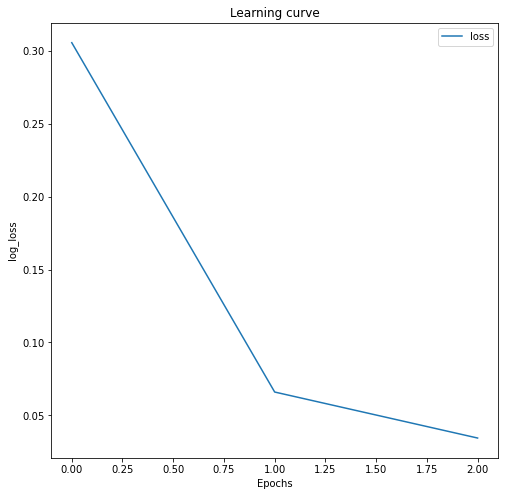

In [10]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
plt.savefig("dice_coef_curve.pdf") 
plt.show()

In [11]:
del train_images, train_masks
model.load_weights('best-segnetmodel.hdf5')

In [17]:
test_images = np.load("images3.npy")
test_masks = np.load("masks3.npy")
test_images = test_images/255
test_masks = test_masks[:,:,:,5]
test_masks[test_masks==1] = 2
test_masks[test_masks==0] = 1
test_masks[test_masks==2] = 0
test_images.shape, test_masks.shape

((2722, 256, 256, 3), (2722, 256, 256))

In [12]:
test_images = np.load("images3.npy")
test_masks = np.load("masks3.npy")
test_images = test_images/255
test_masks = test_masks[:,:,:,5]
test_images.shape, test_masks.shape

((2722, 256, 256, 3), (2722, 256, 256))

In [13]:
model.load_weights('best-segnetmodel.hdf5')
preds_test = model.predict(test_images)
preds_test.shape

(2722, 256, 256, 1)

In [ ]:
preds_test = predict(model=model, inp=None, out_fname=None,
            checkpoints_path='best-segnetmodel.hdf5', overlay_img=False,
            class_names=None, show_legends=False, colors=class_colors,
            prediction_width=None, prediction_height=None,
            read_image_type=1)
preds_test.shape

In [15]:
unique, counts = np.unique(preds_test[0], return_counts=True)
dict(zip(unique, counts))

{0.0: 86,
 2.9802322e-08: 32,
 5.9604645e-08: 28,
 8.940697e-08: 37,
 1.1920929e-07: 35,
 1.4901161e-07: 32,
 1.7881393e-07: 30,
 2.0861626e-07: 38,
 2.3841858e-07: 9,
 2.682209e-07: 26,
 2.9802322e-07: 16,
 3.2782555e-07: 23,
 3.5762787e-07: 27,
 3.874302e-07: 13,
 4.172325e-07: 13,
 4.4703484e-07: 17,
 4.7683716e-07: 4,
 5.066395e-07: 16,
 5.364418e-07: 11,
 5.662441e-07: 18,
 5.9604645e-07: 9,
 6.2584877e-07: 14,
 6.556511e-07: 7,
 6.854534e-07: 12,
 7.1525574e-07: 12,
 7.4505806e-07: 5,
 7.748604e-07: 13,
 8.046627e-07: 5,
 8.34465e-07: 8,
 8.6426735e-07: 12,
 8.940697e-07: 3,
 9.23872e-07: 9,
 9.536743e-07: 9,
 9.834766e-07: 4,
 1.013279e-06: 13,
 1.0430813e-06: 8,
 1.0728836e-06: 3,
 1.1026859e-06: 7,
 1.1324883e-06: 2,
 1.1622906e-06: 4,
 1.1920929e-06: 5,
 1.2218952e-06: 9,
 1.2516975e-06: 7,
 1.2814999e-06: 7,
 1.3113022e-06: 6,
 1.3411045e-06: 9,
 1.3709068e-06: 8,
 1.4007092e-06: 5,
 1.4305115e-06: 7,
 1.4603138e-06: 2,
 1.4901161e-06: 6,
 1.5199184e-06: 7,
 1.5497208e-06: 8

In [16]:
preds_test2 = np.copy(preds_test)

In [17]:
preds_test = np.squeeze(preds_test)
preds_test[preds_test < 0.5] = 0
preds_test[preds_test >= 0.5] = 1
preds_test[preds_test==1] = 2
preds_test[preds_test==0] = 1
preds_test[preds_test==2] = 0
preds_test.shape

(2722, 256, 256)

In [18]:
dice = np.sum(preds_test[test_masks==1]) * 2.0 / (np.sum(preds_test) + np.sum(test_masks))

print('Dice similarity score is {}', format(dice))

Dice similarity score is {} 0.8385399502511156


In [23]:
dice = np.sum(preds_test2[test_masks==1]) * 2.0 / (np.sum(preds_test2) + np.sum(test_masks))

print('Dice similarity score is {}', format(dice))

Dice similarity score is {} 0.33372854036401506


In [24]:
test_masks2 = np.copy(test_masks)
test_masks2[test_masks2==1] = 2
test_masks2[test_masks2==0] = 1
test_masks2[test_masks2==2] = 0

In [25]:
dice = np.sum(preds_test2[test_masks2==1]) * 2.0 / (np.sum(preds_test2) + np.sum(test_masks2))

print('Dice similarity score is {}', format(dice))

Dice similarity score is {} 0.5369758214085997


In [19]:
np.sum(preds_test), np.sum(test_masks), np.sum(preds_test[test_masks==1])

(120015464.0, 143842915.0, 110627896.0)

[1658. 1242. 1952. 1466. 2389.  894.]


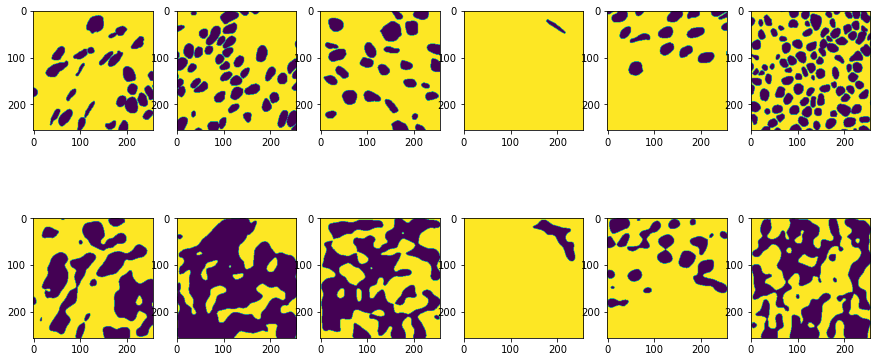

In [26]:
def num_gen():
    n1 = np.zeros(6)
    for i in range(6):
        value = randint(0, (preds_test.shape[0]-1))
        n1[i] = int(value)
    return n1
n1 = num_gen()
print(n1)
a0,a1,a2,a3,a4,a5 = n1[:]
f, axarr = plt.subplots(2,6, figsize=(15,7))
axarr[0,0].imshow(test_masks[int(a0),:,:])
axarr[0,1].imshow(test_masks[int(a1),:,:])
axarr[0,2].imshow(test_masks[int(a2),:,:])
axarr[0,3].imshow(test_masks[int(a3),:,:])
axarr[0,4].imshow(test_masks[int(a4),:,:])
axarr[0,5].imshow(test_masks[int(a5),:,:])
axarr[1,0].imshow(preds_test[int(a0),:,:])
axarr[1,1].imshow(preds_test[int(a1),:,:])
axarr[1,2].imshow(preds_test[int(a2),:,:])
axarr[1,3].imshow(preds_test[int(a3),:,:])
axarr[1,4].imshow(preds_test[int(a4),:,:])
axarr[1,5].imshow(preds_test[int(a5),:,:])

In [21]:
kappa = cohen_kappa_score(test_masks.reshape(test_masks.shape[0]*test_masks.shape[1]*test_masks.shape[2], 1), 
                          preds_test.reshape(preds_test.shape[0]*preds_test.shape[1]*preds_test.shape[2], 1))
kappa

0.3940730993791629

In [33]:
model.load_weights('best-segnetmodel.hdf5')
test_images = np.load("images3.npy")
test_masks = np.load("masks3.npy")
test_images = test_images/255
test_masks = test_masks[:,:,:,5]

In [22]:
score = model.evaluate(test_images, test_masks.reshape(test_masks.shape[0],test_masks.shape[1],test_masks.shape[2], 1), verbose=1)
score

2722/2722 [==============================] - 994s 365ms/step


[6.991060909324495, 0.23882208494120535]